# Depreciation rates

Setup

In [1]:
# Apply magic
%load_ext autoreload
%autoreload 2

# import packages
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
!pip install git+https://github.com/Kristianuruplarsen/pydst.git

from src.data.extract import extract
from src.data.transform import transform

  Cloning https://github.com/Kristianuruplarsen/pydst.git to /private/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/pip-req-build-u0rr278f
  Running command git clone --filter=blob:none --quiet https://github.com/Kristianuruplarsen/pydst.git /private/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/pip-req-build-u0rr278f
  Resolved https://github.com/Kristianuruplarsen/pydst.git to commit 0b41df31af820b81f335a69db09cbf48ba20cca1
  Preparing metadata (setup.py) ... done


### 1. Get data

I extract data on capital and investments from DST's NABK69 tabel. I store the data locally such that the output results always can be retracked back to its source data. 

I call the function data.extract() to extract the data and data.transform() transform data. See source code in src.data folder.

In [2]:
extract()

In [3]:
transform()

I load the data into memory

In [4]:
K = pd.read_csv('data/processed/NABK69_K.csv', index_col=['sector','year','asset'])
I = pd.read_csv('data/processed/NABK69_I.csv', index_col=['sector','year','asset'])
Y = pd.read_csv('data/processed/NIO4F_Y.csv', index_col=['sector','year'])
R = pd.read_csv('data/processed/NIO4F_R.csv', index_col=['sector','year'])
L = pd.read_csv('data/processed/NIO3F_L.csv', index_col=['sector','year'])
T = pd.read_csv('data/processed/NIO3F_T.csv', index_col=['sector','year'])
ir= pd.read_csv('data/processed/MPK100.csv', index_col=['sector','year','asset'])

## Create user cost of capital

Create depreciation rate

In [5]:
# Create delta
K_next = K.groupby(['sector','asset']).shift(-1)
K_diff = K_next.Q - K.Q
delta = (I.Q - K_diff) / K.Q

Create inflaton rate

In [6]:
# Create inflation in investment prices
I_next = I.groupby(['sector','asset']).shift(-1)
pi = I_next.P / I.P - 1
pi_adj = 0.2 * pi + 0.8 * pi.groupby('sector').shift(1)

Create user cost of capital

In [7]:
# create Hall-Jorgensen user cost
uc = I.P * (ir.value - pi_adj + delta)
uc_B = uc.loc[uc.index.get_level_values('asset') == 'B'].droplevel('asset')
uc_M = uc.loc[uc.index.get_level_values('asset') == 'M'].droplevel('asset')

In [8]:
# Restructure capital
K_B = K.loc[K.index.get_level_values('asset') == 'B'].droplevel('asset')
K_M = K.loc[K.index.get_level_values('asset') == 'M'].droplevel('asset')

#Calculate markup
revenue = Y.V
costs = uc_B * K_B.Q + uc_M * K_M.Q + L.V + R.V + T.V
markup = revenue / costs - 1

## Display results

I show the development in revenue and costs across sectors.

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_83657/994434965.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}'.format(x/1000) for x in ax.get_yticks()])


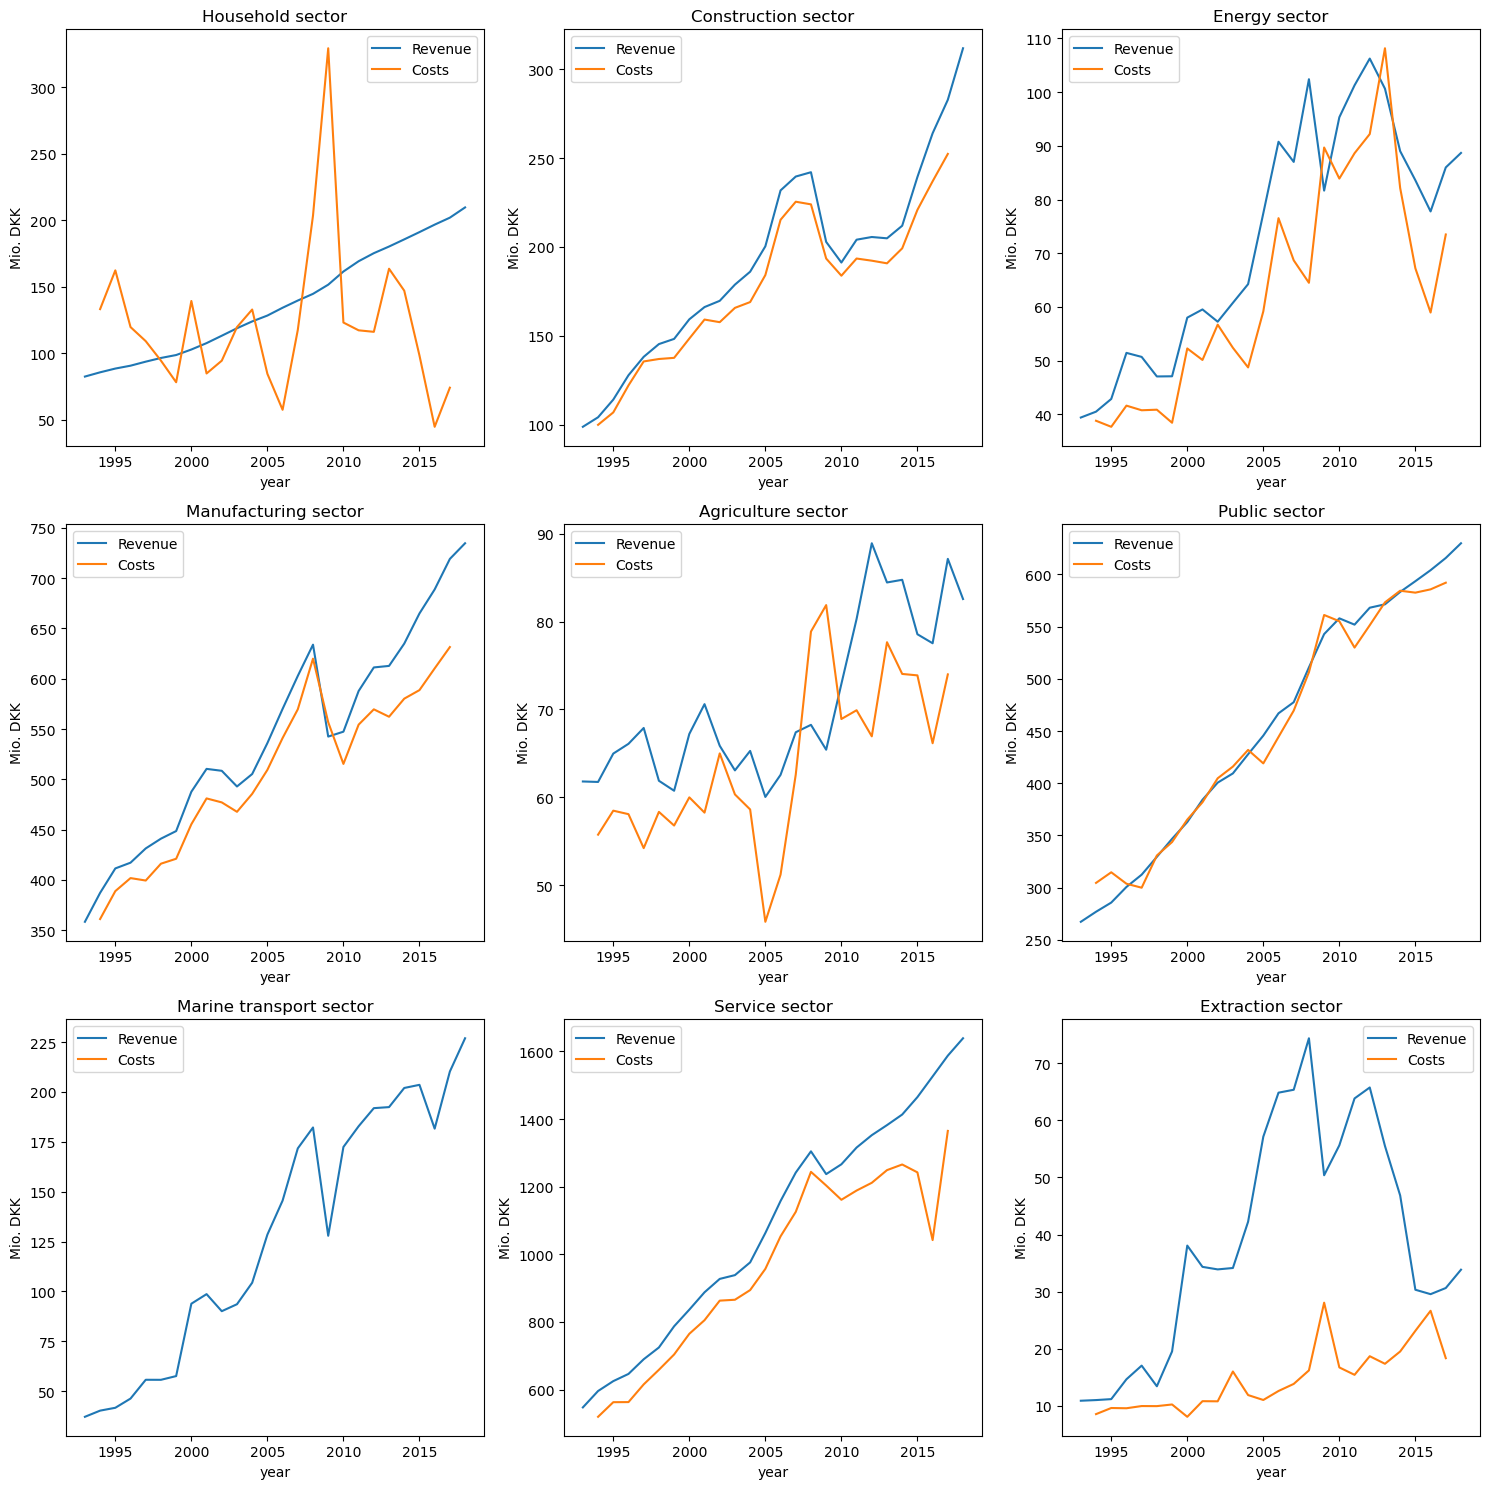

In [9]:
#Make 3x3 grid plot of revenue and costs for all sectors
names = {
    'bol': 'Household sector',
    'byg': 'Construction sector',
    'ene': 'Energy sector',
    'fre': 'Manufacturing sector',
    'lan': 'Agriculture sector',
    'off': 'Public sector',
    'soe': 'Marine transport sector',
    'tje': 'Service sector',
    'udv': 'Extraction sector'
}

fig, ax = plt.subplots(3,3, figsize=(15,15))
axes = ax.flatten()
for i, ax in enumerate(axes):
    sector = markup.index.get_level_values('sector').unique()[i]
    revenue.loc[sector].plot(ax=ax, label='Revenue')
    costs.loc[sector].plot(ax=ax, label='Costs')
    ax.set_yticklabels(['{:.0f}'.format(x/1000) for x in ax.get_yticks()])
    ax.set_ylabel('Mio. DKK')
    ax.set_title(names[sector])
    ax.legend()
plt.tight_layout()
plt.show()

For some sectors the cost measures are quite noisy, but for the big sectors such as manufacturing, construction and services the measures are quite stable. The data is not inflation and growth adjusted so it is natural that there are an upwards trend.

Below I show the development in markups across sectors.

/var/folders/1r/8nkpk12x70q1298b8pv7ghp40000gn/T/ipykernel_83657/2889079583.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])


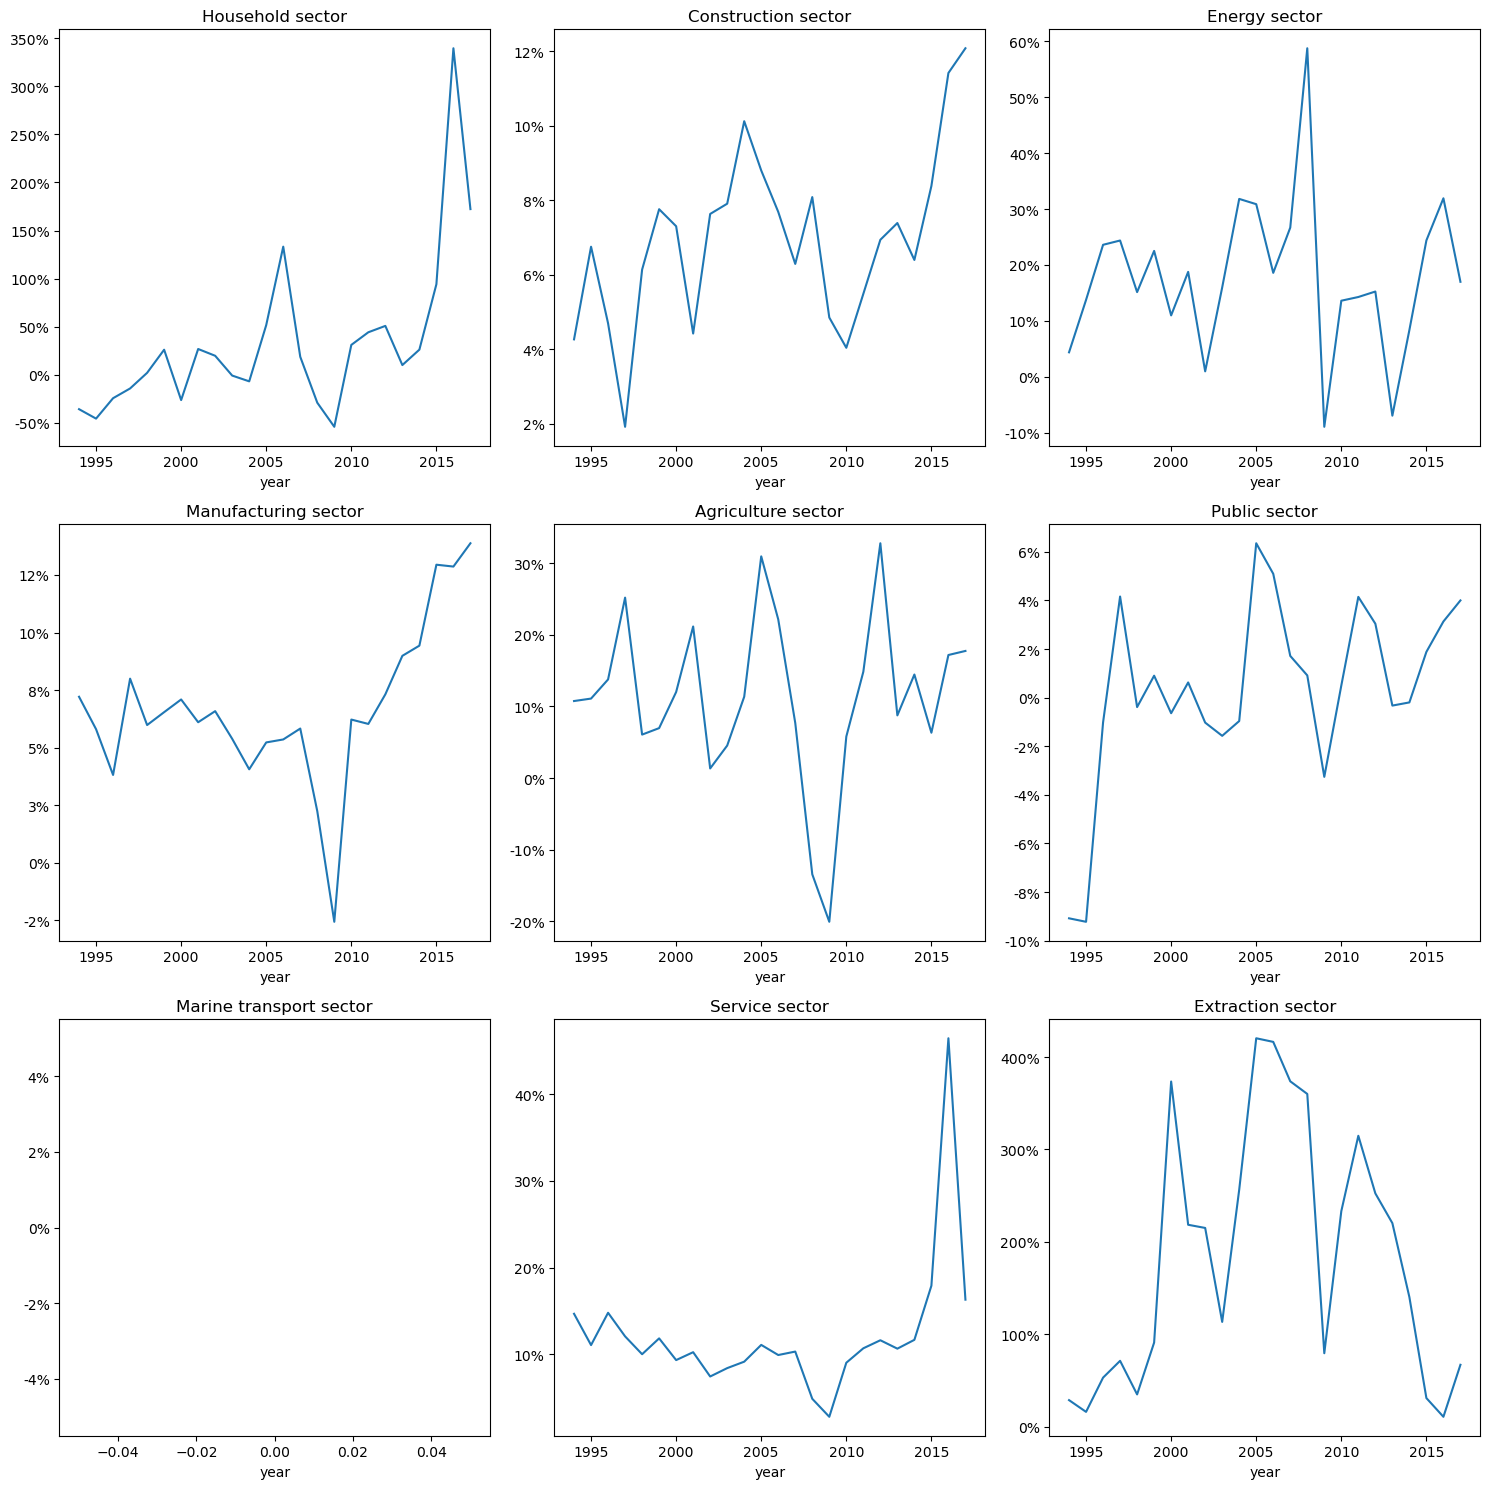

In [10]:
#Make 3x3 grid plot of markups for all sectors
fig, axes = plt.subplots(3,3, figsize=(15,15))
axes = axes.flatten()
for i, ax in enumerate(axes):
    sector = markup.index.get_level_values('sector').unique()[i]
    markup.loc[sector].plot(ax=ax, title=sector)
    ax.set_xlabel('year')
    #Make y-axis labels in percent
    ax.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax.get_yticks()])
    ax.set_title(names[sector])
plt.tight_layout()
plt.show()

The markups are in general quite noisy due to the noisy cost measures. More work could be done on this. There is no clear conclusion regarding a trend in markups. However it is apparent that there are differences in the average markup across sectors. The table below shows this as well.

In [11]:
markup.groupby('sector').describe()

,count,mean,std,min,25%,50%,75%,max
sector,,,,,,,,
bol,24.0,0.338234,0.844231,-0.539694,-0.166487,0.193181,0.459439,3.395208
byg,24.0,0.069445,0.023443,0.019151,0.053248,0.071164,0.079478,0.120757
ene,24.0,0.177543,0.139274,-0.089522,0.129500,0.164862,0.243820,0.587739
fre,24.0,0.066813,0.034488,-0.025631,0.053772,0.061628,0.074870,0.138783
lan,24.0,0.112356,0.118526,-0.200993,0.062679,0.112363,0.173397,0.328196
off,24.0,0.003663,0.037639,-0.092231,-0.009769,0.005630,0.030654,0.063534
soe,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tje,24.0,0.121832,0.079847,0.028002,0.092917,0.106762,0.118980,0.464400
udv,24.0,1.830962,1.387930,0.109378,0.637082,1.777670,2.710924,4.202652


The extraction sector has an extraudinary high markup. The energy sector also has a really high markup. Interestingly agriculture has a high markup which I wouldn't have expected. I would like to look more into this. More checks could be done on the data.